# Data Processing

In [5]:
!unzip /content/Stanford40_JPEGImages.zip -d /content
!unzip /content/scenes.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/JPEGImages/phoning_170.jpg  
  inflating: /content/JPEGImages/phoning_171.jpg  
  inflating: /content/JPEGImages/phoning_172.jpg  
  inflating: /content/JPEGImages/phoning_173.jpg  
  inflating: /content/JPEGImages/phoning_174.jpg  
  inflating: /content/JPEGImages/phoning_175.jpg  
  inflating: /content/JPEGImages/phoning_176.jpg  
  inflating: /content/JPEGImages/phoning_177.jpg  
  inflating: /content/JPEGImages/phoning_178.jpg  
  inflating: /content/JPEGImages/phoning_179.jpg  
  inflating: /content/JPEGImages/phoning_180.jpg  
  inflating: /content/JPEGImages/phoning_181.jpg  
  inflating: /content/JPEGImages/phoning_182.jpg  
  inflating: /content/JPEGImages/phoning_183.jpg  
  inflating: /content/JPEGImages/phoning_184.jpg  
  inflating: /content/JPEGImages/phoning_185.jpg  
  inflating: /content/JPEGImages/phoning_186.jpg  
  inflating: /content/JPEGImages/phoning_187.jpg  
  inflating: /content/JPEGImage

In [34]:
import os
import random

random.seed(6)
imgs_all = random.sample(os.listdir('/content/JPEGImages'), 60)
imgs_all = ['/content/JPEGImages/' + img for img in imgs_all]
imgs_scene = ['/content/scenes/' + img for img in os.listdir('/content/scenes')]
imgs_all.extend(imgs_scene)

In [35]:
imgs_all

['/content/JPEGImages/applauding_098.jpg',
 '/content/JPEGImages/washing_dishes_087.jpg',
 '/content/JPEGImages/looking_through_a_telescope_155.jpg',
 '/content/JPEGImages/writing_on_a_book_082.jpg',
 '/content/JPEGImages/playing_guitar_192.jpg',
 '/content/JPEGImages/climbing_069.jpg',
 '/content/JPEGImages/writing_on_a_book_166.jpg',
 '/content/JPEGImages/jumping_016.jpg',
 '/content/JPEGImages/jumping_054.jpg',
 '/content/JPEGImages/cutting_trees_096.jpg',
 '/content/JPEGImages/playing_violin_218.jpg',
 '/content/JPEGImages/riding_a_horse_155.jpg',
 '/content/JPEGImages/texting_message_021.jpg',
 '/content/JPEGImages/riding_a_horse_016.jpg',
 '/content/JPEGImages/playing_guitar_076.jpg',
 '/content/JPEGImages/applauding_058.jpg',
 '/content/JPEGImages/reading_125.jpg',
 '/content/JPEGImages/blowing_bubbles_066.jpg',
 '/content/JPEGImages/blowing_bubbles_246.jpg',
 '/content/JPEGImages/cutting_vegetables_105.jpg',
 '/content/JPEGImages/running_029.jpg',
 '/content/JPEGImages/phoning_

# Caption Generation

In [2]:
!pip install transformers timm fairscale
!git clone https://github.com/salesforce/BLIP
%cd BLIP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 30.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.2 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332112 sha256=6c82d1641c9d6c13ea7c6b30916ff3f73c1f0698b851dd9b6a18e1bcabe344ff
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898

In [22]:
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(path, device):
    raw_image = Image.open(path).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((200,200),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

In [23]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model = blip_decoder(pretrained=model_url, image_size=200, vit='base')
model.eval()
model = model.to(device)

100%|██████████| 1.97G/1.97G [00:27<00:00, 75.8MB/s]


reshape position embedding from 196 to 144
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [ ]:
captions = []
for img in imgs_all:
  with torch.no_grad():
    caption = model.generate(load_image(img, device), sample=True, top_p=0.9, max_length=25, min_length=15)
    print(caption[0])
    captions.append(caption[0])

In [66]:
import csv

with open("/content/img_captions.csv", 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  writer.writerow(["DOC_ID", "Caption", "Path"])
  for i in range(len(captions)):
    writer.writerow([i, captions[i], imgs_all[i]])

# DB Construction

In [38]:
!pip install thirdai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyTrie: filename=PyTrie-0.4.0-py3-none-any.whl size=6081 sha256=c46974325cadf3d0b944b7387331d443e6616abb4aaa1b36adfcfc466ddb6f54
  Stored in directory: /root/.cache/pip/wheels/87/0e/a3/3563272cb57af4afbc50c4c7882dd4540944aadde25c82bd45
Successfully built PyTrie


In [39]:
from thirdai import licensing
licensing.activate("")

from thirdai import neural_db as ndb

db = ndb.NeuralDB(user_id="test")
db.from_scratch()

In [163]:
db.from_scratch()

In [138]:
from thirdai_utils import CSV

csv_files = ['/content/img_captions.csv']
csv_docs = []

for file in csv_files:
    csv_doc = CSV(
        path=file,
        id_column="DOC_ID",
        strong_columns=["Caption"],
        weak_columns=["Caption"],
        reference_columns=["Path"])

    csv_docs.append(csv_doc)

In [164]:
source_ids = db.insert(csv_docs, train=True)

loaded data | source 'Documents:
img_captions.csv' | vectors 211 | batches 1 | time 0s | complete

train | epoch 0 | train_steps 1 | train_hash_precision@5=0.0104265  | train_batches 1 | time 1s

loaded data | source 'Documents:
img_captions.csv' | vectors 211 | batches 1 | time 0s | complete

train | epoch 0 | train_steps 2 | train_hash_precision@5=0.707109  | train_batches 1 | time 1s

loaded data | source 'Documents:
img_captions.csv' | vectors 211 | batches 1 | time 0s | complete

train | epoch 0 | train_steps 3 | train_hash_precision@5=0.723223  | train_batches 1 | time 1s

loaded data | source 'Documents:
img_captions.csv' | vectors 211 | batches 1 | time 0s | complete

train | epoch 0 | train_steps 4 | train_hash_precision@5=0.679621  | train_batches 1 | time 1s

loaded data | source 'Documents:
img_captions.csv' | vectors 211 | batches 1 | time 0s | complete

train | epoch 0 | train_steps 5 | train_hash_precision@5=0.854028  | train_batches 1 | time 1s

loaded data | source 'Do

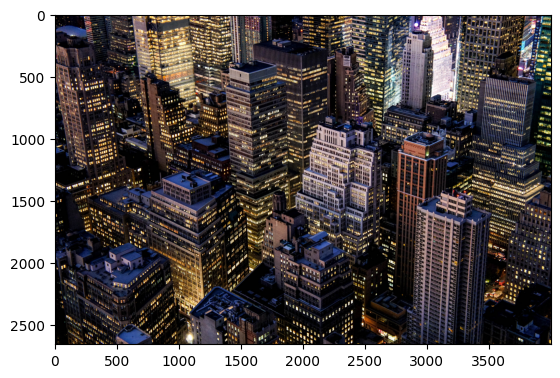

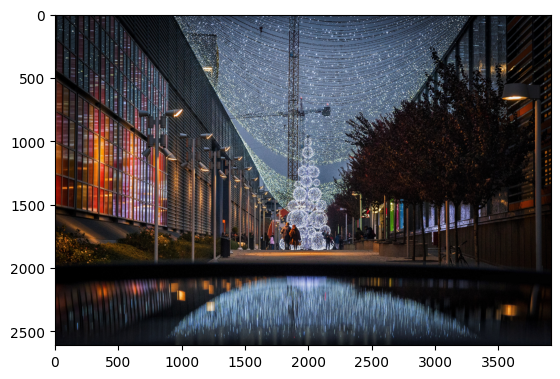

In [165]:
import matplotlib.pyplot as plt

search_results = db.search(
    query="city night",
    top_k=2,
    on_error=lambda error_msg: print(f"Error! {error_msg}"))

for result in search_results:
    res = plt.imread(result.text())
    plt.figure()
    plt.imshow(res)

In [166]:
# RLHF

rabbits = ["rabbit", "bunny"]
for w1 in rabbits:
  for w2 in rabbits:
    db.associate(source=w1, target=w2)

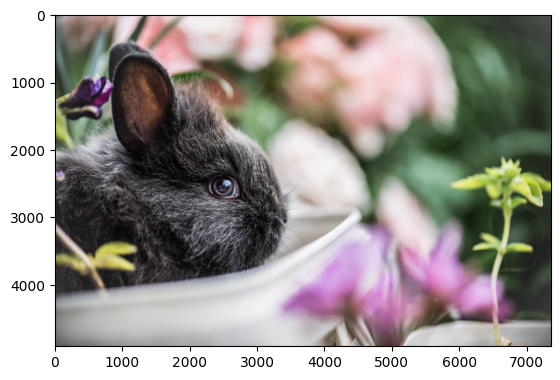

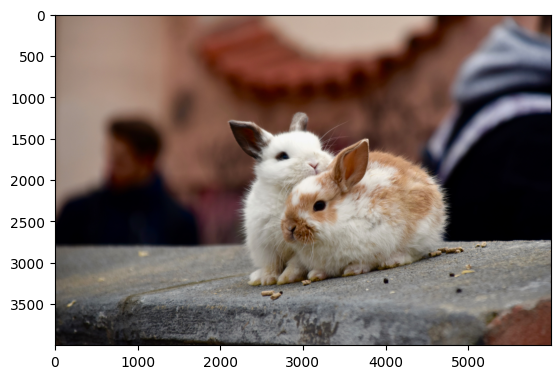

In [167]:
search_results = db.search(
    query="rabbit",
    top_k=2,
    on_error=lambda error_msg: print(f"Error! {error_msg}"))

for result in search_results:
    res = plt.imread(result.text())
    plt.figure()
    plt.imshow(res)